In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_fusion'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 794.36it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
       
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    #optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:18<00:00, 15.29img/s]

***
ensemble_fusion Loss: 1.0317449569702148


Epoch 1/50:  99%|█████████▊| 200/203 [00:24<00:00,  8.16img/s]

---
ensemble_fusion Validation Dice Loss: 1.3595292568206787
ensemble_fusion Validation Pixel Accuracy: 0.16014607747395834
ensemble_fusion Validation MIoU: 0.08182612777518164
ensemble_fusion Validation Dice Score: 0.2899535298347473



Epoch 2/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.11img/s]

***
ensemble_fusion Loss: 0.9367094039916992


Epoch 2/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.82img/s]

---
ensemble_fusion Validation Dice Loss: 1.1015448570251465
ensemble_fusion Validation Pixel Accuracy: 0.59318488940858
ensemble_fusion Validation MIoU: 0.3944204633154309
ensemble_fusion Validation Dice Score: 0.44289159774780273



Epoch 3/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.30img/s]

***
ensemble_fusion Loss: 0.8797383308410645


Epoch 3/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.94img/s]

---
ensemble_fusion Validation Dice Loss: 0.979465663433075
ensemble_fusion Validation Pixel Accuracy: 0.7465078788891173
ensemble_fusion Validation MIoU: 0.5354284337767887
ensemble_fusion Validation Dice Score: 0.5651578307151794



Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.30img/s]

***
ensemble_fusion Loss: 0.7935484647750854


Epoch 4/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.99img/s]

---
ensemble_fusion Validation Dice Loss: 0.7947622537612915
ensemble_fusion Validation Pixel Accuracy: 0.88227897777892
ensemble_fusion Validation MIoU: 0.7068974568593497
ensemble_fusion Validation Dice Score: 0.717570424079895



Epoch 5/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.10img/s]

***
ensemble_fusion Loss: 0.7465286254882812


Epoch 5/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.16img/s]

---
ensemble_fusion Validation Dice Loss: 0.7790592908859253
ensemble_fusion Validation Pixel Accuracy: 0.9225271124588815
ensemble_fusion Validation MIoU: 0.7772561526469659
ensemble_fusion Validation Dice Score: 0.7568867206573486



Epoch 6/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.20img/s]

***
ensemble_fusion Loss: 0.7094006538391113


Epoch 6/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.01img/s]

---
ensemble_fusion Validation Dice Loss: 0.7365318536758423
ensemble_fusion Validation Pixel Accuracy: 0.9241346392715186
ensemble_fusion Validation MIoU: 0.7804221696662222
ensemble_fusion Validation Dice Score: 0.8140894174575806



Epoch 7/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
ensemble_fusion Loss: 0.6701526641845703


Epoch 7/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.93img/s]

---
ensemble_fusion Validation Dice Loss: 0.7065083384513855
ensemble_fusion Validation Pixel Accuracy: 0.9217446310478344
ensemble_fusion Validation MIoU: 0.7765909679183567
ensemble_fusion Validation Dice Score: 0.8137723803520203



Epoch 8/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.15img/s]

***
ensemble_fusion Loss: 0.6758028268814087


Epoch 8/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.05img/s]

---
ensemble_fusion Validation Dice Loss: 0.6702936887741089
ensemble_fusion Validation Pixel Accuracy: 0.9349017226905153
ensemble_fusion Validation MIoU: 0.8041781467976927
ensemble_fusion Validation Dice Score: 0.8304392099380493



Epoch 9/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
ensemble_fusion Loss: 0.6022939682006836


Epoch 9/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.95img/s]

---
ensemble_fusion Validation Dice Loss: 0.6508827805519104
ensemble_fusion Validation Pixel Accuracy: 0.9343569571511787
ensemble_fusion Validation MIoU: 0.8032523359153114
ensemble_fusion Validation Dice Score: 0.8330568671226501



Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.07img/s]

***
ensemble_fusion Loss: 0.589275062084198


Epoch 10/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.90img/s]

---
ensemble_fusion Validation Dice Loss: 0.6399232149124146
ensemble_fusion Validation Pixel Accuracy: 0.9408456902754935
ensemble_fusion Validation MIoU: 0.8192251586328603
ensemble_fusion Validation Dice Score: 0.842472493648529



Epoch 11/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
ensemble_fusion Loss: 0.5962647199630737


Epoch 11/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.95img/s]

---
ensemble_fusion Validation Dice Loss: 0.6265427470207214
ensemble_fusion Validation Pixel Accuracy: 0.9371958950109649
ensemble_fusion Validation MIoU: 0.790517706917675
ensemble_fusion Validation Dice Score: 0.8312169909477234



Epoch 12/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.16img/s]

***
ensemble_fusion Loss: 0.6093767881393433


Epoch 12/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.93img/s]

---
ensemble_fusion Validation Dice Loss: 0.6361514329910278
ensemble_fusion Validation Pixel Accuracy: 0.9242882979543585
ensemble_fusion Validation MIoU: 0.7839455263868156
ensemble_fusion Validation Dice Score: 0.8223808407783508



Epoch 13/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
ensemble_fusion Loss: 0.5573556423187256


Epoch 13/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.96img/s]

---
ensemble_fusion Validation Dice Loss: 0.6156051754951477
ensemble_fusion Validation Pixel Accuracy: 0.9317958898711622
ensemble_fusion Validation MIoU: 0.7987288862919715
ensemble_fusion Validation Dice Score: 0.8393055200576782



Epoch 14/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.79img/s]

***
ensemble_fusion Loss: 0.5613158941268921


Epoch 14/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.74img/s]

---
ensemble_fusion Validation Dice Loss: 0.6049493551254272
ensemble_fusion Validation Pixel Accuracy: 0.9381293581243146
ensemble_fusion Validation MIoU: 0.8118459151263557
ensemble_fusion Validation Dice Score: 0.8572900891304016



Epoch 15/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.10img/s]

***
ensemble_fusion Loss: 0.5852397680282593


Epoch 15/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.80img/s]

---
ensemble_fusion Validation Dice Loss: 0.5998563766479492
ensemble_fusion Validation Pixel Accuracy: 0.943878173828125
ensemble_fusion Validation MIoU: 0.8262795098069085
ensemble_fusion Validation Dice Score: 0.8625354766845703



Epoch 16/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.13img/s]

***
ensemble_fusion Loss: 0.5379776358604431


Epoch 16/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.95img/s]

---
ensemble_fusion Validation Dice Loss: 0.5706131458282471
ensemble_fusion Validation Pixel Accuracy: 0.9549033181709156
ensemble_fusion Validation MIoU: 0.8508422920785872
ensemble_fusion Validation Dice Score: 0.8713139891624451



Epoch 17/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.86img/s]

***
ensemble_fusion Loss: 0.5693075656890869


Epoch 17/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.89img/s]

---
ensemble_fusion Validation Dice Loss: 0.5878067016601562
ensemble_fusion Validation Pixel Accuracy: 0.9477423952336896
ensemble_fusion Validation MIoU: 0.835776985147477
ensemble_fusion Validation Dice Score: 0.8655697107315063



Epoch 18/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
ensemble_fusion Loss: 0.5351011753082275


Epoch 18/50:  99%|█████████▊| 200/203 [00:20<00:00, 10.00img/s]

---
ensemble_fusion Validation Dice Loss: 0.5756385922431946
ensemble_fusion Validation Pixel Accuracy: 0.9546805933902138
ensemble_fusion Validation MIoU: 0.8505170957275872
ensemble_fusion Validation Dice Score: 0.8769635558128357



Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.86img/s]

***
ensemble_fusion Loss: 0.5158641338348389


Epoch 19/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.99img/s]

---
ensemble_fusion Validation Dice Loss: 0.575503408908844
ensemble_fusion Validation Pixel Accuracy: 0.9540788081654331
ensemble_fusion Validation MIoU: 0.8500673092272477
ensemble_fusion Validation Dice Score: 0.878295361995697



Epoch 20/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.08img/s]

***
ensemble_fusion Loss: 0.5306717157363892


Epoch 20/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.02img/s]

---
ensemble_fusion Validation Dice Loss: 0.5814690589904785
ensemble_fusion Validation Pixel Accuracy: 0.9505481385348136
ensemble_fusion Validation MIoU: 0.8417616878289212
ensemble_fusion Validation Dice Score: 0.8777284622192383



Epoch 21/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.85img/s]

***
ensemble_fusion Loss: 0.5192639827728271


Epoch 21/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.95img/s]

---
ensemble_fusion Validation Dice Loss: 0.56232750415802
ensemble_fusion Validation Pixel Accuracy: 0.9604577850877193
ensemble_fusion Validation MIoU: 0.8657825003405695
ensemble_fusion Validation Dice Score: 0.8781477808952332



Epoch 22/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.16img/s]

***
ensemble_fusion Loss: 0.5286232233047485


Epoch 22/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.95img/s]

---
ensemble_fusion Validation Dice Loss: 0.5810543298721313
ensemble_fusion Validation Pixel Accuracy: 0.9526854397957785
ensemble_fusion Validation MIoU: 0.8473344421673595
ensemble_fusion Validation Dice Score: 0.8772755861282349



Epoch 23/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
ensemble_fusion Loss: 0.5461207628250122


Epoch 23/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.83img/s]

---
ensemble_fusion Validation Dice Loss: 0.5828454494476318
ensemble_fusion Validation Pixel Accuracy: 0.9482729727761787
ensemble_fusion Validation MIoU: 0.8362376629019054
ensemble_fusion Validation Dice Score: 0.8732694983482361



Epoch 24/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
ensemble_fusion Loss: 0.5366436243057251


Epoch 24/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.99img/s]

---
ensemble_fusion Validation Dice Loss: 0.5746963024139404
ensemble_fusion Validation Pixel Accuracy: 0.9513410601699561
ensemble_fusion Validation MIoU: 0.844172208294262
ensemble_fusion Validation Dice Score: 0.8754457831382751



Epoch 25/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.06img/s]

***
ensemble_fusion Loss: 0.5182073712348938


Epoch 25/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.82img/s]

---
ensemble_fusion Validation Dice Loss: 0.5619262456893921
ensemble_fusion Validation Pixel Accuracy: 0.9568462706448739
ensemble_fusion Validation MIoU: 0.8562501734430192
ensemble_fusion Validation Dice Score: 0.8798078894615173



Epoch 26/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.95img/s]

***
ensemble_fusion Loss: 0.5479855537414551


Epoch 26/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.62img/s]

---
ensemble_fusion Validation Dice Loss: 0.5914667844772339
ensemble_fusion Validation Pixel Accuracy: 0.9437973290158991
ensemble_fusion Validation MIoU: 0.8270258921623935
ensemble_fusion Validation Dice Score: 0.8644925951957703



Epoch 27/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
ensemble_fusion Loss: 0.5420140027999878


Epoch 27/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.83img/s]

---
ensemble_fusion Validation Dice Loss: 0.5782191753387451
ensemble_fusion Validation Pixel Accuracy: 0.9511732134902686
ensemble_fusion Validation MIoU: 0.8439337952255801
ensemble_fusion Validation Dice Score: 0.8788966536521912



Epoch 28/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
ensemble_fusion Loss: 0.5523726940155029


Epoch 28/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.72img/s]

---
ensemble_fusion Validation Dice Loss: 0.5804591178894043
ensemble_fusion Validation Pixel Accuracy: 0.9499219927871436
ensemble_fusion Validation MIoU: 0.8410008810205611
ensemble_fusion Validation Dice Score: 0.8730881810188293



Epoch 29/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
ensemble_fusion Loss: 0.5489726066589355


Epoch 29/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.79img/s]

---
ensemble_fusion Validation Dice Loss: 0.5863250494003296
ensemble_fusion Validation Pixel Accuracy: 0.9482531631202028
ensemble_fusion Validation MIoU: 0.8373377776502774
ensemble_fusion Validation Dice Score: 0.873612105846405



Epoch 30/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.70img/s]

***
ensemble_fusion Loss: 0.5546427965164185


Epoch 30/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.74img/s]

---
ensemble_fusion Validation Dice Loss: 0.5779234170913696
ensemble_fusion Validation Pixel Accuracy: 0.9518507572642544
ensemble_fusion Validation MIoU: 0.8451937189742851
ensemble_fusion Validation Dice Score: 0.8785406947135925



Epoch 31/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.02img/s]

***
ensemble_fusion Loss: 0.5736263990402222


Epoch 31/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.79img/s]

---
ensemble_fusion Validation Dice Loss: 0.5912657976150513
ensemble_fusion Validation Pixel Accuracy: 0.9446901020250822
ensemble_fusion Validation MIoU: 0.8290036924848561
ensemble_fusion Validation Dice Score: 0.8669757843017578



Epoch 32/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.99img/s]

***
ensemble_fusion Loss: 0.5258061289787292


Epoch 32/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.64img/s]

---
ensemble_fusion Validation Dice Loss: 0.5716756582260132
ensemble_fusion Validation Pixel Accuracy: 0.9534307111773574
ensemble_fusion Validation MIoU: 0.8485475449194122
ensemble_fusion Validation Dice Score: 0.8827872276306152



Epoch 33/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.96img/s]

***
ensemble_fusion Loss: 0.5386055707931519


Epoch 33/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.62img/s]

---
ensemble_fusion Validation Dice Loss: 0.5767577886581421
ensemble_fusion Validation Pixel Accuracy: 0.9528626559073465
ensemble_fusion Validation MIoU: 0.8480887616822488
ensemble_fusion Validation Dice Score: 0.8781067132949829



Epoch 34/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
ensemble_fusion Loss: 0.5621346831321716


Epoch 34/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.87img/s]

---
ensemble_fusion Validation Dice Loss: 0.5826599597930908
ensemble_fusion Validation Pixel Accuracy: 0.9473644055818257
ensemble_fusion Validation MIoU: 0.834697249866573
ensemble_fusion Validation Dice Score: 0.8727613687515259



Epoch 35/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.09img/s]

***
ensemble_fusion Loss: 0.5449208617210388


Epoch 35/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.91img/s]

---
ensemble_fusion Validation Dice Loss: 0.5788045525550842
ensemble_fusion Validation Pixel Accuracy: 0.9496422483209979
ensemble_fusion Validation MIoU: 0.8403283891527579
ensemble_fusion Validation Dice Score: 0.8764660954475403



Epoch 36/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
ensemble_fusion Loss: 0.524327278137207


Epoch 36/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.90img/s]

---
ensemble_fusion Validation Dice Loss: 0.5751237273216248
ensemble_fusion Validation Pixel Accuracy: 0.9524592349403783
ensemble_fusion Validation MIoU: 0.8470367254109911
ensemble_fusion Validation Dice Score: 0.8786413073539734



Epoch 37/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.06img/s]

***
ensemble_fusion Loss: 0.5456812381744385


Epoch 37/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.91img/s]

---
ensemble_fusion Validation Dice Loss: 0.5758923292160034
ensemble_fusion Validation Pixel Accuracy: 0.9528241073876097
ensemble_fusion Validation MIoU: 0.8480636253198761
ensemble_fusion Validation Dice Score: 0.878212571144104



Epoch 38/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.82img/s]

***
ensemble_fusion Loss: 0.5242722034454346


Epoch 38/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.71img/s]

---
ensemble_fusion Validation Dice Loss: 0.5781734585762024
ensemble_fusion Validation Pixel Accuracy: 0.9520769621196546
ensemble_fusion Validation MIoU: 0.8453658108096453
ensemble_fusion Validation Dice Score: 0.8800363540649414



Epoch 39/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.88img/s]

***
ensemble_fusion Loss: 0.5309967994689941


Epoch 39/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.67img/s]

---
ensemble_fusion Validation Dice Loss: 0.5718801021575928
ensemble_fusion Validation Pixel Accuracy: 0.9524897525185033
ensemble_fusion Validation MIoU: 0.8469366178411873
ensemble_fusion Validation Dice Score: 0.8773090243339539



Epoch 40/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.77img/s]

***
ensemble_fusion Loss: 0.536129355430603


Epoch 40/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.85img/s]

---
ensemble_fusion Validation Dice Loss: 0.5785696506500244
ensemble_fusion Validation Pixel Accuracy: 0.9497782389322916
ensemble_fusion Validation MIoU: 0.8407503184549314
ensemble_fusion Validation Dice Score: 0.8740407228469849



Epoch 41/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.78img/s]

***
ensemble_fusion Loss: 0.5261054039001465


Epoch 41/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.59img/s]

---
ensemble_fusion Validation Dice Loss: 0.5731436014175415
ensemble_fusion Validation Pixel Accuracy: 0.9537407055235746
ensemble_fusion Validation MIoU: 0.8498092993107985
ensemble_fusion Validation Dice Score: 0.8822037577629089



Epoch 42/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
ensemble_fusion Loss: 0.5425175428390503


Epoch 42/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.66img/s]

---
ensemble_fusion Validation Dice Loss: 0.5851155519485474
ensemble_fusion Validation Pixel Accuracy: 0.946729158100329
ensemble_fusion Validation MIoU: 0.8329604894386091
ensemble_fusion Validation Dice Score: 0.8728620409965515



Epoch 43/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.85img/s]

***
ensemble_fusion Loss: 0.5127602815628052


Epoch 43/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.67img/s]

---
ensemble_fusion Validation Dice Loss: 0.5750135183334351
ensemble_fusion Validation Pixel Accuracy: 0.9528747023197642
ensemble_fusion Validation MIoU: 0.8477423747788908
ensemble_fusion Validation Dice Score: 0.8811715245246887



Epoch 44/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
ensemble_fusion Loss: 0.5568863153457642


Epoch 44/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.69img/s]

---
ensemble_fusion Validation Dice Loss: 0.5850061178207397
ensemble_fusion Validation Pixel Accuracy: 0.9475207412452028
ensemble_fusion Validation MIoU: 0.8352900009571997
ensemble_fusion Validation Dice Score: 0.87176913022995



Epoch 45/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
ensemble_fusion Loss: 0.5412355065345764


Epoch 45/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.82img/s]

---
ensemble_fusion Validation Dice Loss: 0.576962411403656
ensemble_fusion Validation Pixel Accuracy: 0.9532243159779331
ensemble_fusion Validation MIoU: 0.8489495271492064
ensemble_fusion Validation Dice Score: 0.8769240379333496



Epoch 46/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.78img/s]

***
ensemble_fusion Loss: 0.5502555966377258


Epoch 46/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.84img/s]

---
ensemble_fusion Validation Dice Loss: 0.5787382125854492
ensemble_fusion Validation Pixel Accuracy: 0.9514390376576206
ensemble_fusion Validation MIoU: 0.8448011548503005
ensemble_fusion Validation Dice Score: 0.8763276934623718



Epoch 47/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
ensemble_fusion Loss: 0.537366509437561


Epoch 47/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.96img/s]

---
ensemble_fusion Validation Dice Loss: 0.5817420482635498
ensemble_fusion Validation Pixel Accuracy: 0.9502906130071271
ensemble_fusion Validation MIoU: 0.8406880576032464
ensemble_fusion Validation Dice Score: 0.8794589042663574



Epoch 48/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
ensemble_fusion Loss: 0.5322145819664001


Epoch 48/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.75img/s]

---
ensemble_fusion Validation Dice Loss: 0.5703463554382324
ensemble_fusion Validation Pixel Accuracy: 0.9553865131578947
ensemble_fusion Validation MIoU: 0.8542887404697259
ensemble_fusion Validation Dice Score: 0.8775972723960876



Epoch 49/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.83img/s]

***
ensemble_fusion Loss: 0.5652972459793091


Epoch 49/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.80img/s]

---
ensemble_fusion Validation Dice Loss: 0.5755050778388977
ensemble_fusion Validation Pixel Accuracy: 0.9528830009594298
ensemble_fusion Validation MIoU: 0.8483111404103489
ensemble_fusion Validation Dice Score: 0.8778521418571472



Epoch 50/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
ensemble_fusion Loss: 0.5350799560546875


Epoch 50/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.75img/s]

---
ensemble_fusion Validation Dice Loss: 0.5803301334381104
ensemble_fusion Validation Pixel Accuracy: 0.9505952533922697
ensemble_fusion Validation MIoU: 0.8418114044825499
ensemble_fusion Validation Dice Score: 0.8767547011375427


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

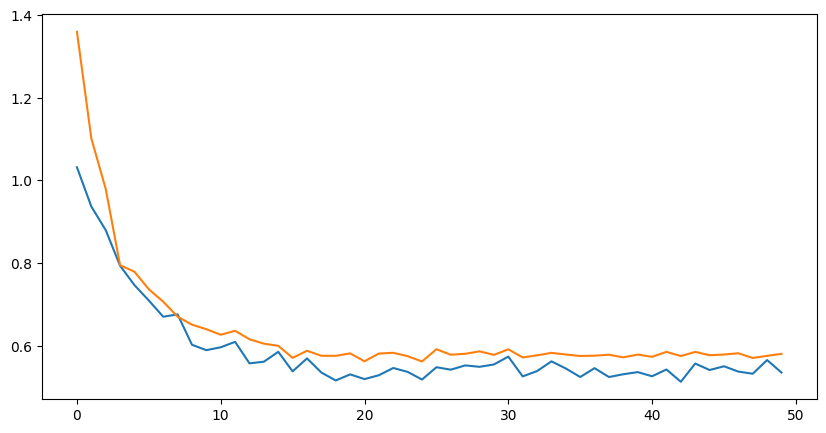

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

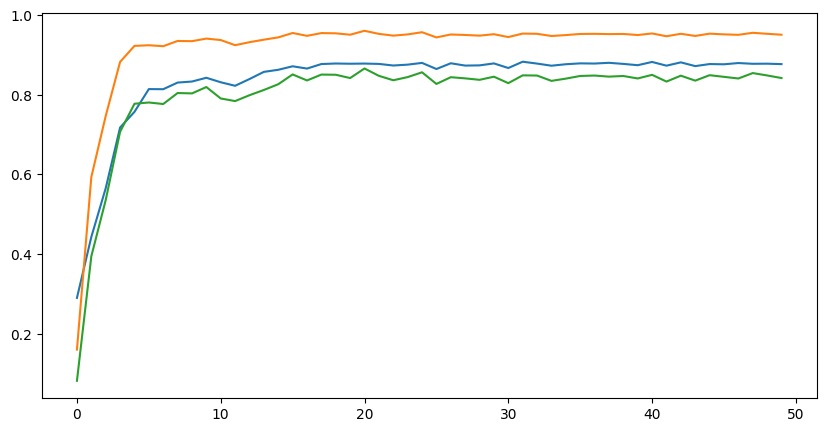

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)